# Filtering Based Image Enhancement


**image filtering** : memodifikasi gambar berdasarkan beberapa fungsi ketetanggan lokal pada setiap piksel

Contoh sederhana : linear filtering (convolution)
- mengganti nilai piksel individu dengan hasil kombinasi linear tetangganya
- menggunakan *mask/kernel/filter* dengan ukuran nxn (diutamakan n ganjil)
- Ilustrasi : 
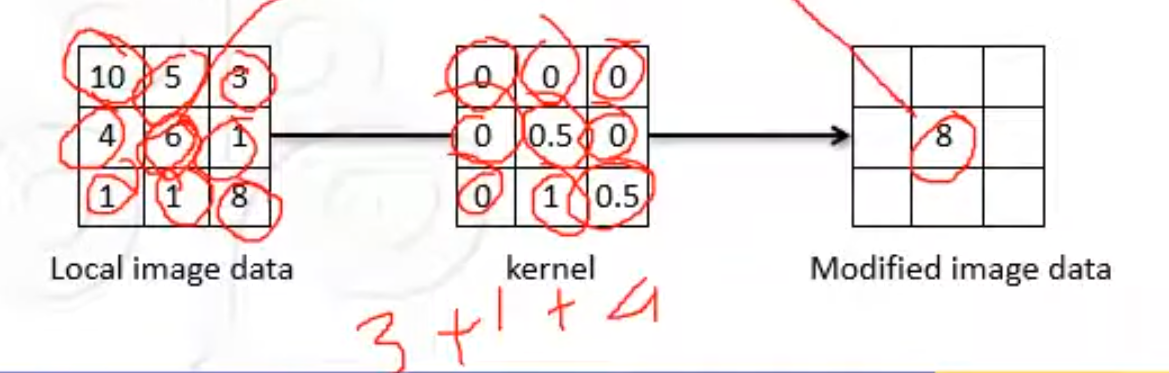
- fungsi filtering :
    1. sharpening (penajaman)
    2. smoothing (bluring)


## 1. Correlation

**Correlation** : adalah proses memanipulasi dua gambar dengan menumpuknya satu sama lain. Gambar pertama disebut gambar, sedangkan gambar kedua disebut sebagai filter/mask/kernel. Nilai piksel dalam kernel disebut koefisien kernel. Karena besarnya koefisien tidak berubah seiring bergesernya kernel, proses ini disebut *linear filtering*

In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

import cv2 
import matplotlib.pyplot as plt 
import os 
import urllib3 
from tqdm import tqdm


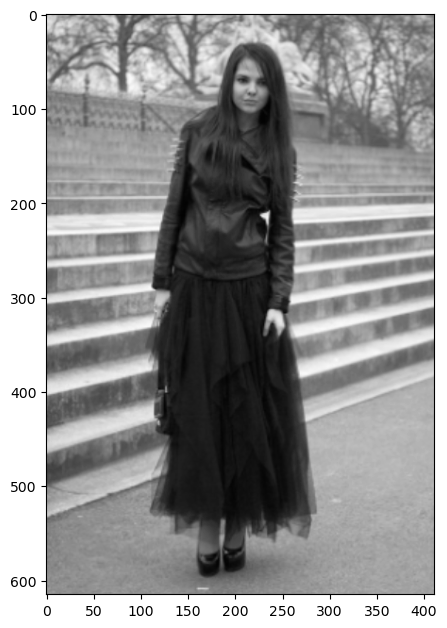

In [2]:
# The Image
image = cv.imread('img/girl-fashion.png')
image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
plt.figure(figsize=(5, 8))
plt.imshow(image, cmap='gray', vmin=0, vmax=256)
plt.show()

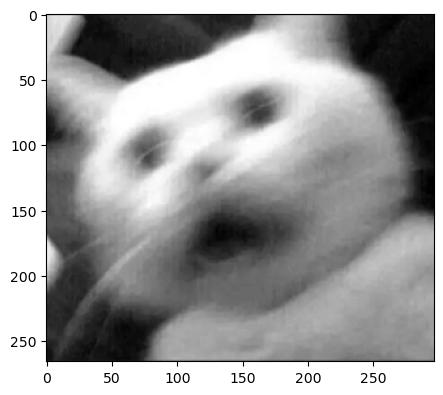

In [3]:
# The Mask
mask = cv.imread('img/mask.png')
mask = cv.cvtColor(mask, cv.COLOR_BGR2GRAY)
plt.figure(figsize=(5, 5))
plt.imshow(mask, cmap='gray')  # Pastikan grayscale ditampilkan
plt.show()


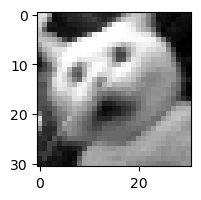

In [4]:
# resize to a smaller mask for better computational speed
mask_resized = cv.resize(mask, (31, 31))
plt.figure(figsize=(2, 2))
plt.imshow(mask_resized, cmap='gray')
plt.show()

In [5]:
image.shape, mask.shape, mask_resized.shape

((615, 411), (266, 297), (31, 31))

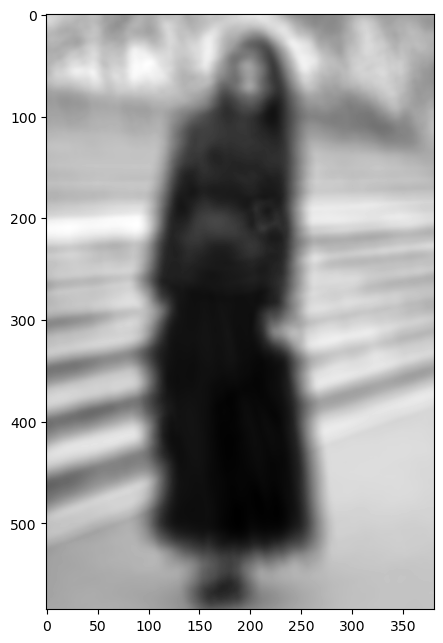

CPU times: total: 125 ms
Wall time: 2.31 s


In [6]:
%%time
# Perform correlation by sliding the mask over the image pixel-by-pixel
result_rows = image.shape[0]-mask_resized.shape[0] + 1
result_columns = image.shape[1]-mask_resized.shape[1] + 1
result = np.zeros([result_rows, result_columns])

# normalize the mask before processing
mask_resized = mask_resized/255

# cross correlation 
for r in range(result_rows):
    for c in range(result_columns):
        # mengalikan element wise setiap piksel dari gambar dan mask dari posisi r sampai r+tinggi mask dan dari c sampai c+lebar mask
        val = np.multiply(image[r:r+mask_resized.shape[0], c:c+mask_resized.shape[1]], mask_resized) 
        # menjumlahkan hasil perkalian piksel
        val = np.sum(np.ravel(val)) # ravel digunakan untuk menguraikan array 2d menjadi 1d untuk kemudahan penjumlahan
        # nilai akhir val yang dinormalisasi disimpan balik ke result 
        result[r][c] = val/np.prod(mask_resized.shape)

plt.figure(figsize=(5, 8))
plt.imshow(result, cmap='gray')
plt.show()

## 2. Auto-correlation

**Auto correlation** adalah proses mengkorelasikan gambar dengan dirinya sendiri. Ini artinya, gambar menjadi mask dengan sendirinya.

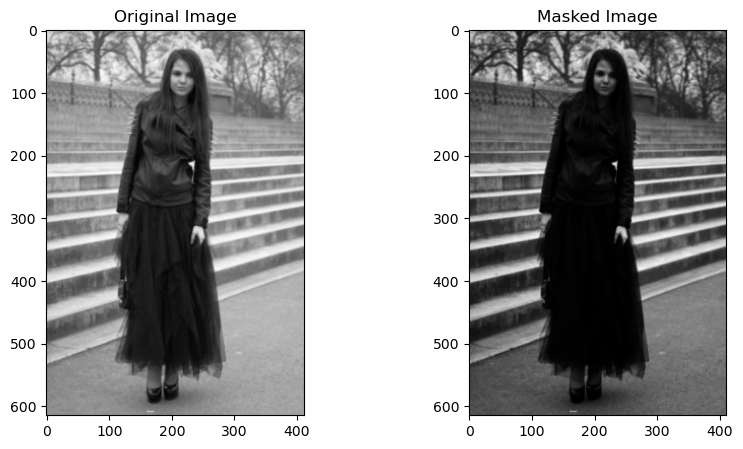

In [7]:
# read the image
image = cv.imread('img/girl-fashion.png')

# copy the image to a new variable
mask = image/255

# apply the mask
result = np.array(np.multiply(image, mask), dtype=np.uint8) # uint8 = 0-255, penting agbr intensitas berada dalam tipe int

# display the result
_,(ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(image, cmap='gray')
ax2.imshow(result, cmap='gray')
ax1.set_title('Original Image')
ax2.set_title('Masked Image')
plt.show()

In [8]:
image.min(), mask.max(), result.min()

(2, 0.984313725490196, 0)

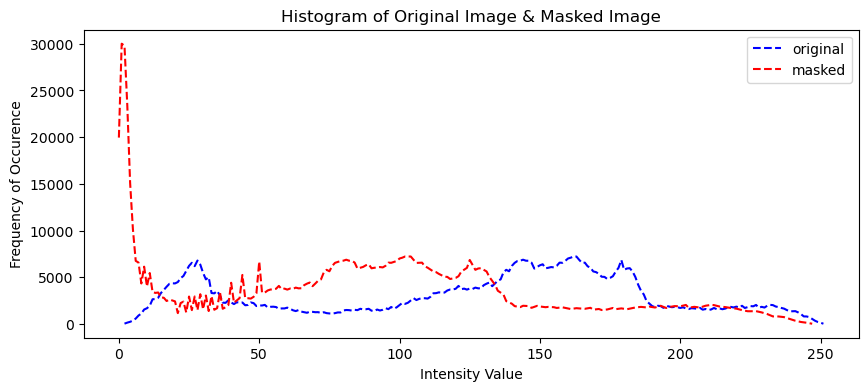

In [9]:
plt.figure(figsize=(10, 4))

# histogram of original image
intensity, count = np.unique(image, return_counts=True)
plt.plot(intensity, count, '--b', label='original')

# histogram of masked image
intensity, count = np.unique(result, return_counts=True)
plt.plot(intensity, count, '--r', label='masked')

plt.title('Histogram of Original Image & Masked Image')
plt.xlabel('Intensity Value')
plt.ylabel('Frequency of Occurence')
plt.legend()
plt.show()

## 3. Convolution

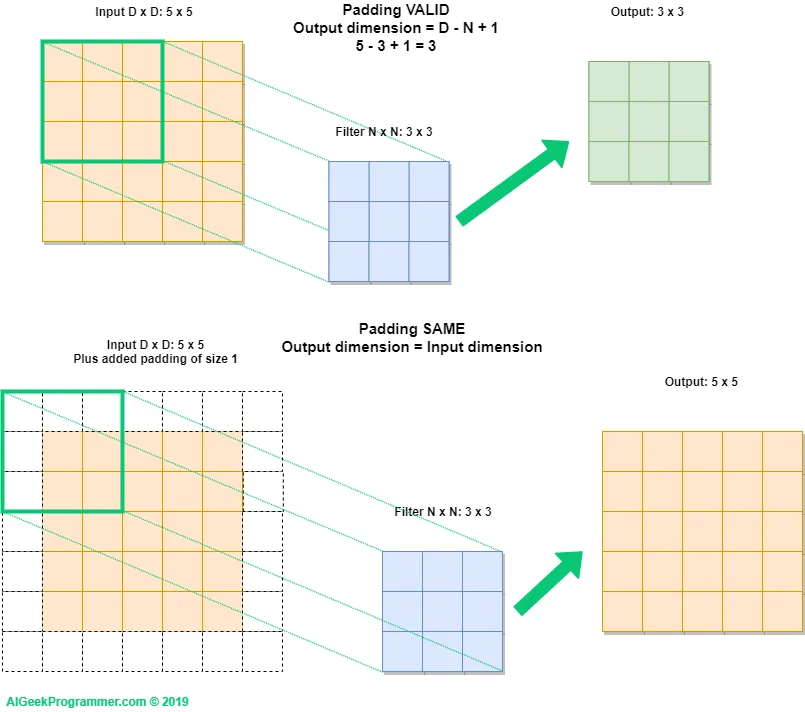

In [10]:
# define separate functions for both convolution and cross-correlation 
# so that they will be very handy in the future.


def cross_correlate(img, mask, padding='valid'):
    """
    The function uses padding to return the required image size.
    Mask is expected to be smaller than or equal to Image by size.
    Mask should have odd-numbered-shapes to do meaningful padding.
    Mask needs not to be square in shape
    Input image and mask should be in grayscale (for simplicity)
    """
    if mask.shape[0]>img.shape[0] or mask.shape[1]>img.shape[1]:
        raise Exception('Mask is bigger than Image!')
    if len(mask.shape)>2 or len(img.shape)>2:
        raise Exception('Please convert inputs to grayscale!')
    
    result_size = [0,0]
    
    # valid padding - returns image of smaller size than the original
    if padding=='valid':
        result_size[0] = img.shape[0] - mask.shape[0] + 1
        result_size[1] = img.shape[1] - mask.shape[1] + 1
        padded = img[:] # to have a common variable during convolution
        
    else:
        pad_size = [0,0] 
        padded_size = [0,0]
        # full padding - returns bigger image than the original
        if padding=='full':
            pad_size[0] = mask.shape[0] - 1
            pad_size[1] = mask.shape[1] - 1
            result_size[0] = img.shape[0] + mask.shape[0] - 1
            result_size[1] = img.shape[1] + mask.shape[1] - 1
        # same padding - returns image of size equal to original image
        if padding=='same':
            pad_size[0] = int((mask.shape[0] - 1)/2)
            pad_size[1] = int((mask.shape[1] - 1)/2)
            result_size[0] = img.shape[0]
            result_size[1] = img.shape[1] 
        padded_size[0] = img.shape[0] + pad_size[0]*2
        padded_size[1] = img.shape[1] + pad_size[1]*2
        # formulate a dummy padded image
        padded = np.zeros(padded_size)
        # pad the input image
        if pad_size[0] == 0:
            padded[:,pad_size[1]:-pad_size[1]] = img[:]
        elif pad_size[1] == 0:
            padded[pad_size[0]:-pad_size[0],:] = img[:]
        else:
            padded[pad_size[0]:-pad_size[0],pad_size[1]:-pad_size[1]] = img[:]
        
    
    # formulate a dummy result
    result = np.zeros(result_size)
    
    # peform cross-correlation
    for r in tqdm(range(result.shape[0])):
        for c in range(result.shape[1]):
            # we are now at result[r][c]
            val = np.multiply(padded[r:r+mask.shape[0],c:c+mask.shape[1]], mask)
            val = np.sum(np.ravel(val))
            result[r][c] = val
    
    return result
                  
def convolve(img, mask, padding='valid'):
    flipped = mask[::-1, ::-1]
    # once mask is double-flipped, convolution resembles cross-correlation
    return cross_correlate(img, flipped, padding)

# catat : perbedaan cross-correlation dan convolution adalah mask dari proses convolusi mengalami double rotation

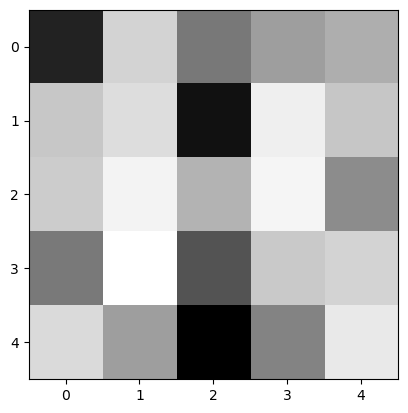

In [11]:
mask = np.random.random([5,5])
plt.imshow(mask, cmap='gray')
plt.show()

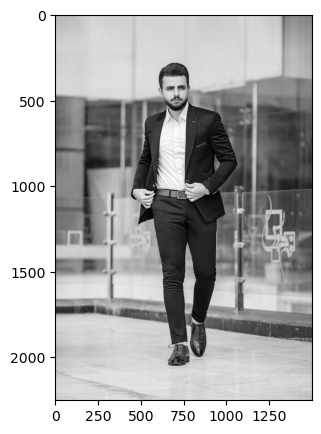

In [12]:
# load an image
image = cv.imread('img/men-fashion.jpeg')

# convert to grayscale
image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

plt.figure(figsize=(5, 5))
plt.imshow(image, cmap='gray')
plt.show()


100%|██████████| 2247/2247 [00:14<00:00, 154.42it/s]


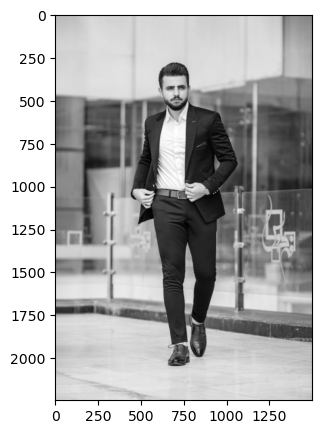

In [14]:
# apply cross-correlation
result = convolve(image, mask, padding='valid')/np.prod(mask.shape)

plt.figure(figsize=(5, 5))
plt.imshow(result, cmap='gray')
plt.show()

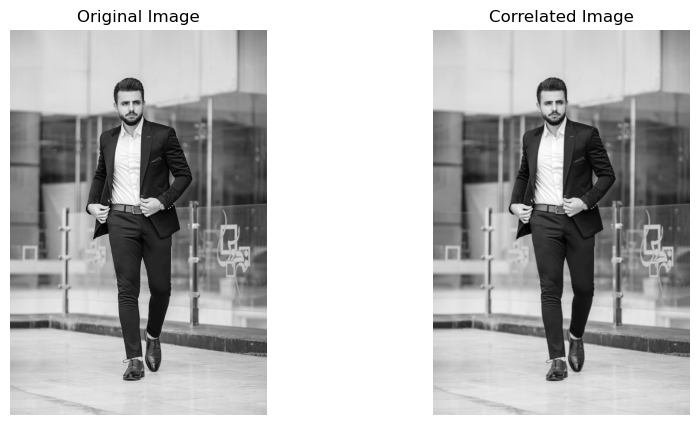

In [ ]:
image_to_show = [image, result]
titles = ['Original Image', 'Correlated Image']
plt.figure(figsize=(10, 5))
for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.imshow(image_to_show[i], cmap='gray')
    plt.title(titles[i])
    plt.axis('off')
plt.show()